In [ ]:
import sys, os

!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/atari_wrappers.py
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/utils.py
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/replay_buffer.py
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week04_approx_rl/framebuffer.py

!touch .setup_complete

In [ ]:
!pip install stable-baselines3[extra] pyvirtualdisplay gym[atari] pyglet 
!pip install atari-py==0.2.5
!apt-get install unrar

!wget http://www.atarimania.com/roms/Roms.rar 
!unrar x Roms.rar 
!unzip ROMS.zip
!python -m atari_py.import_roms ROMS

In [1]:
import random
import numpy as np
import torch
import utils
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/Users/jacob/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
ENV_NAME = "BreakoutNoFrameskip-v4"

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/Users/jacob/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
/Users/jacob/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


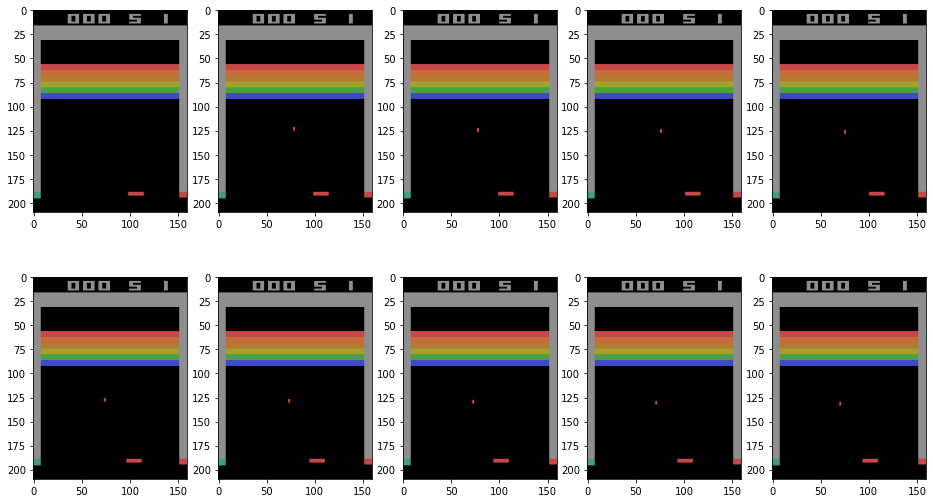

In [3]:
env = gym.make(ENV_NAME, render_mode="rgb_array")
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

In [4]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import cv2
from PIL import Image

class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        super().__init__(env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)

    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return np.dot(rgb[... , :3], channel_weights)

    def observation(self, img):
        """what happens to each observation"""
        imgc = img[30:-15, 5:-5]
        resized = cv2.resize(imgc, self.img_size[1:])
        grayscaled = np.array(self._to_gray_scale(resized) / 255, dtype = np.float32)
        return grayscaled.reshape(self.img_size)

In [5]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    assert 'NoFrameskip' in env.spec.id
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)
    env = atari_wrappers.EpisodicLifeEnv(env)
    env = atari_wrappers.FireResetEnv(env)
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)
    env = PreprocessAtariObs(env)
    return env

In [6]:
from framebuffer import FrameBuffer

def make_env(clip_rewards=True):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

/Users/jacob/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(4, (4, 64, 64))

/Users/jacob/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


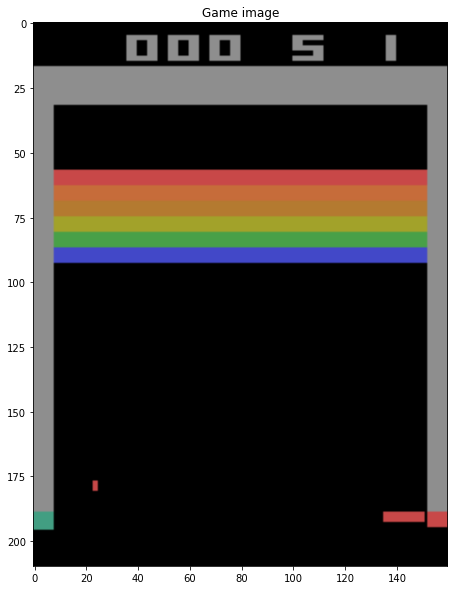

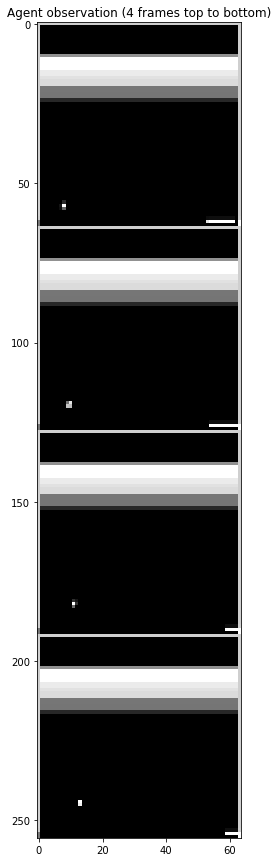

In [7]:
for _ in range(12):
    obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

plt.figure(figsize=[15,15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

In [8]:
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
device

device(type='cpu')

In [10]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        self.encode = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size = (3, 3), stride=2),
            nn.ELU(),
            nn.Conv2d(16, 32, kernel_size = 3, stride=2),
            nn.ELU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride=2),
            nn.ELU(),
            nn.Flatten(start_dim = 1),
        )
        
        self.advantage = nn.Linear(3136, n_actions)
        self.value = nn.Linear(3136, 1)

        nn.init.orthogonal_(self.encode[0].weight, gain = np.sqrt(2))
        nn.init.orthogonal_(self.encode[2].weight, gain = np.sqrt(2))
        nn.init.orthogonal_(self.encode[4].weight, gain = np.sqrt(2))
        nn.init.zeros_(self.encode[0].bias)
        nn.init.zeros_(self.encode[2].bias)
        nn.init.zeros_(self.encode[4].bias)

    def forward(self, state_t):
        encoded = self.encode(state_t)
        qvalues = self.value(encoded) + self.advantage(encoded) - self.advantage(encoded).mean(dim = -1).reshape((-1, 1))
        return qvalues

    def get_qvalues(self, states):
        model_device = next(self.parameters()).device
        states = torch.tensor(states, device=model_device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape

        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [11]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [12]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000, seed=None):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset(seed=seed)
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [13]:
evaluate(env, agent, n_games=1)

/var/folders/_j/n1j73z4j0g14gw6cprm8h7100000gn/T/ipykernel_12009/342705544.py:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  states = torch.tensor(states, device=model_device, dtype=torch.float32)


0.0

In [14]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float32)    # shape: [batch_size, *state_shape]
    actions = torch.tensor(actions, device=device, dtype=torch.int64)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float32)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)

    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float32,
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)  # shape: [batch_size, n_actions]
    
    #predicted_next_actions = torch.argmax(agent(next_states), dim = -1)

    # compute q-values for all actions in next states
    predicted_next_qvalues = target_network(next_states)  # shape: [batch_size, n_actions]
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(len(actions)), actions]  # shape: [batch_size]
    
    next_state_values = predicted_next_qvalues.max(axis=1)[0]
    
    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.

    target_qvalues_for_actions = rewards + is_not_done * gamma * next_state_values

    # mean squared error loss to minimize
    difference = (predicted_qvalues_for_actions - target_qvalues_for_actions.detach())
    return difference

def compute_weight(state, action, reward, next_state, is_done,
                    agent, target_network,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):

    is_not_done = 1 - is_done
    predicted_qvalues = agent.get_qvalues([state])  # shape: [batch_size, n_actions]
    predicted_next_actions = np.argmax(agent.get_qvalues([next_state]))
    predicted_next_qvalues = target_network.get_qvalues([next_state])  # shape: [batch_size, n_actions]
    predicted_qvalues_for_actions = predicted_qvalues[range(1), predicted_next_actions]  # shape: [batch_size]
    next_state_values = predicted_next_qvalues.max(axis=1)[0]
    target_qvalues_for_actions = reward + is_not_done * gamma * next_state_values
    loss = np.abs(predicted_qvalues_for_actions - target_qvalues_for_actions)

    return loss

In [15]:
# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.n_entries = 0

    # update to the root node
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    # find sample on leaf node
    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        return self.tree[0]

    # store priority and sample
    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    # update priority
    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    # get priority and sample
    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

import random

class DataStorage:
    def __init__(self):
        self.sd, self.ad, self.rd, self.s_d, self.t_d = [], [], [], [], []
        
    def put(self, data):
        s, a, r, s_, t = data
        self.sd.append(s)
        self.ad.append(a)
        self.rd.append(r)
        self.s_d.append(s_)
        self.t_d.append(t)
        
    def load(self):
        return np.array(self.sd), np.array(self.ad), np.array(self.rd), np.array(self.s_d), np.array(self.t_d)
    
class ReplayBuffer:  # stored as ( s, a, r, s_ ) in SumTree
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.capacity = capacity

    def _get_priority(self, error):
        return (np.abs(error) + self.e) ** self.a

    def add(self, error, sample):
        p = self._get_priority(error)
        self.tree.add(p, sample)

    def sample(self, n):
        batch = DataStorage()
        idxs = []
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.put(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
        is_weight = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        is_weight /= is_weight.max()

        return batch, idxs, is_weight

    def update(self, idx, error):
        p = self._get_priority(error)
        self.tree.update(idx, p)
    
    def __len__(self):
        return self.tree.n_entries

In [16]:
def play_and_record(initial_state, agent, target_network, env, exp_replay, n_steps=1):
    sum_rewards = 0
    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([initial_state])
        action = qvalues.argmax(axis=-1)[0]
        s, r, terminated, truncated, _ = env.step(action)
        sum_rewards += r
        exp_replay.add(compute_weight(initial_state, action, r, s, terminated, agent, target_network),
                       (initial_state, action, r, s, terminated))
        if terminated or truncated:
            s, _ = env.reset()
        initial_state = s
    return sum_rewards, s


In [17]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [18]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

seed = 5772
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [20]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)
agent.load_state_dict(torch.load('agent.pth', map_location=torch.device('cpu')))
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [21]:
REPLAY_BUFFER_SIZE = 10**5
N_STEPS = 100

exp_replay = ReplayBuffer(REPLAY_BUFFER_SIZE)
for i in trange(REPLAY_BUFFER_SIZE // N_STEPS):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """
             )
        break
    play_and_record(state, agent, target_network, env, exp_replay, n_steps=N_STEPS)
    
    if len(exp_replay) == REPLAY_BUFFER_SIZE:
        break
print(len(exp_replay))

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/_j/n1j73z4j0g14gw6cprm8h7100000gn/T/ipykernel_12009/4194572469.py:55: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.tree[idx] = p
/var/folders/_j/n1j73z4j0g14gw6cprm8h7100000gn/T/ipykernel_12009/4194572469.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.tree[parent] += change
  0%|          | 3/1000 [00:05<30:49,  1.85s/it]


KeyboardInterrupt: 

In [22]:
timesteps_per_epoch = 1
batch_size = 32
total_steps = 5 * 10**5
decay_steps = 5 * 10**5

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 0.9
final_epsilon = 0.05

loss_freq = 50
refresh_target_network_freq = 2000
eval_freq = 2000

max_grad_norm = 50

n_lives = 5

In [23]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []
step = 0

In [24]:
import time

def wait_for_keyboard_interrupt():
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        pass

In [ ]:
state, _ = env.reset()
with trange(step, total_steps + 1) as progress_bar:
    for step in progress_bar:
        if not utils.is_enough_ram():
            print('less that 100 Mb RAM available, freezing')
            print('make sure everything is ok and use KeyboardInterrupt to continue')
            wait_for_keyboard_interrupt()

        agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

        # play
        _, state = play_and_record(state, agent, target_network, env, exp_replay, timesteps_per_epoch)

        # train
        data_batch, idxs, is_weight = exp_replay.sample(batch_size)
        obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = data_batch.load()
        
        difference = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
        errors = torch.abs(difference).cpu().data.numpy()

        # update priority
        for i in range(batch_size):
            idx = idxs[i]
            exp_replay.update(idx, errors[i])
            
        loss = torch.mean(difference ** 2)
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
        opt.step()
        opt.zero_grad()
        if step % loss_freq == 0:
            td_loss_history.append(loss.data.cpu().item())
            grad_norm_history.append(grad_norm.cpu())

        if step % refresh_target_network_freq == 0:
            # Load agent weights into target_network
            target_network.load_state_dict(agent.state_dict())

        if step % eval_freq == 0:
            mean_rw_history.append(mean_rw := evaluate(
                make_env(clip_rewards=True), agent, n_games=3 * n_lives, greedy=True, seed=step)
            )
            initial_state_q_values = agent.get_qvalues(
                [make_env().reset(seed=step)[0]]
            )
            initial_state_v_history.append(np.max(initial_state_q_values))

            clear_output(True)
            print("buffer size = %i, epsilon = %.5f, mean_reward = %.5f" %
                (len(exp_replay), agent.epsilon, mean_rw))

            plt.figure(figsize=[16, 9])

            plt.subplot(2, 2, 1)
            plt.title("Mean reward per life")
            plt.plot(mean_rw_history)
            plt.grid()

            assert not np.isnan(td_loss_history[-1])
            plt.subplot(2, 2, 2)
            plt.title("TD loss history (smoothened)")
            plt.plot(utils.smoothen(td_loss_history))
            plt.grid()

            plt.subplot(2, 2, 3)
            plt.title("Initial state V")
            plt.plot(initial_state_v_history)
            plt.grid()

            plt.subplot(2, 2, 4)
            plt.title("Grad norm history (smoothened)")
            plt.plot(utils.smoothen(grad_norm_history))
            plt.grid()

            plt.show()

In [ ]:
torch.save(agent.state_dict(), 'agent.pth')

In [34]:
final_score = evaluate(
  make_env(clip_rewards=False),
    agent, n_games=30, greedy=True, t_max=10 * 1000, seed=9
)
print('final score:', final_score)
assert final_score >= 3, 'not as cool as DQN can'
print('Cool!')

/Users/jacob/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


final score: 3.6
Cool!


In [26]:
from gymnasium.wrappers import RecordVideo

with make_env() as env, RecordVideo(
    env=env, video_folder="./videos", episode_trigger=lambda episode_number: True
) as env_monitor:
    sessions = [
        evaluate(env_monitor, agent, n_games=3) for _ in range(5)
    ]

Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-0.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-0.mp4


Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-1.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-1.mp4


Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-2.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-2.mp4
Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-3.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-3.mp4
Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-4.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-4.mp4


Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-5.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-5.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-5.mp4


Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-6.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-6.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-6.mp4


Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-7.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-7.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-7.mp4
Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-8.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-8.mp4


Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-9.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-9.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-9.mp4
Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-10.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-10.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-10.mp4
Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-11.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-11.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-11.mp4


Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-12.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-12.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-12.mp4
Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-13.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-13.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-13.mp4
Moviepy - Building video /Users/jacob/Desktop/videos/rl-video-episode-14.mp4.
Moviepy - Writing video /Users/jacob/Desktop/videos/rl-video-episode-14.mp4



Moviepy - Done !
Moviepy - video ready /Users/jacob/Desktop/videos/rl-video-episode-14.mp4


In [33]:
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[random.choice(range(len(video_paths)))]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))